<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [85]:
!pip install datasets

Импорт необходимых библиотек

In [86]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import string

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [87]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khapi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [89]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [90]:
sentences = []
word_threshold = 32

for text in tqdm(dataset['train']['text']):
    for sentence in sent_tokenize(text):
        processed_sentence = sentence.lower().translate(
            str.maketrans('', '', string.punctuation)
        )
        if len(processed_sentence) > word_threshold:
            sentences.append(processed_sentence)

# Получить отдельные предложения и поместить их в sentences

  0%|          | 0/25000 [00:00<?, ?it/s]

In [91]:
print("Всего предложений:", len(sentences))

Всего предложений: 238327


Посчитаем для каждого слова его встречаемость.

In [92]:
words = Counter()
for text in tqdm(dataset['train']['text']):
    processed_text = text.lower().translate(
        str.maketrans('', '', string.punctuation)
    )

    for word in word_tokenize(processed_text):
        words[word] += 1

# Расчет встречаемости слов

  0%|          | 0/25000 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [93]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 600

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

# Наполнение словаря

In [94]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab

In [95]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 961


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [96]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [97]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx].lower().translate(
            str.maketrans('', '', string.punctuation)
        )
        tokenized_sentence = [self.bos_id]
        # Допишите код здесь
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
        ]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [98]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [99]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [100]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    return np.mean(perplexity)

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [101]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    history = {
        'train_loss': [],
        'val_perplexity': []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_losses = []
        for batch in tqdm(train_loader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        history['train_loss'].append(np.mean(epoch_losses))
        history['val_perplexity'].append(evaluate(model, criterion, val_loader))

    return history

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [102]:
class LanguageModel(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_rate: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.func = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embedding = self.embedding(input_batch)
        output, _ = self.lstm(embedding)
        last_embedding = self.dropout(self.linear(self.func(output)))
        projection = self.projection(self.func(last_embedding))
        return projection

In [103]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())

In [105]:
history = train_model(model, criterion, optimizer, train_dataloader, eval_dataloader)

Training epoch 1::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/5959 [00:00<?, ?it/s]

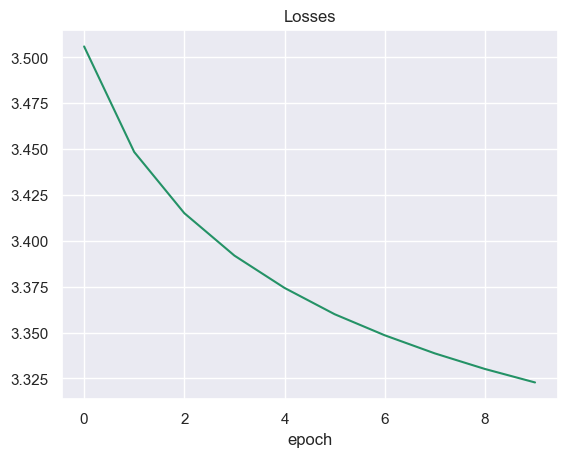

In [106]:
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'])
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

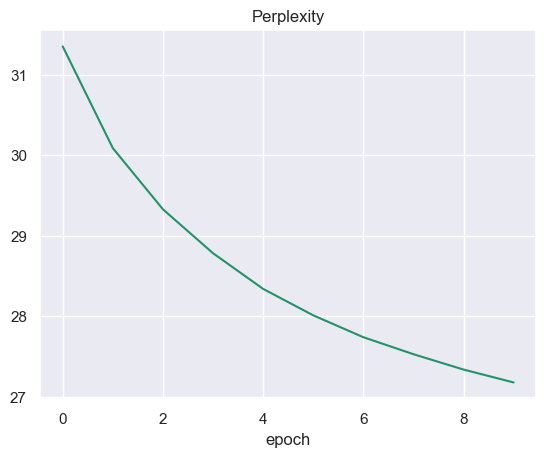

In [107]:
plt.plot(np.arange(len(history['val_perplexity'])), history['val_perplexity'])
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [111]:
class LanguageModel2(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_rate: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.func = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embedding = self.embedding(input_batch)
        output, _ = self.lstm(embedding)
        last_embedding = self.dropout(self.linear(self.func(output)))
        projection = self.projection(self.func(last_embedding))
        return projection

In [112]:
# Проведите второй эксперимент
model2 = LanguageModel2(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion2 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer2 = torch.optim.AdamW(model.parameters())

In [113]:
history2 = train_model(model2, criterion2, optimizer2, train_dataloader, eval_dataloader)

Training epoch 1::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/5959 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/5959 [00:00<?, ?it/s]

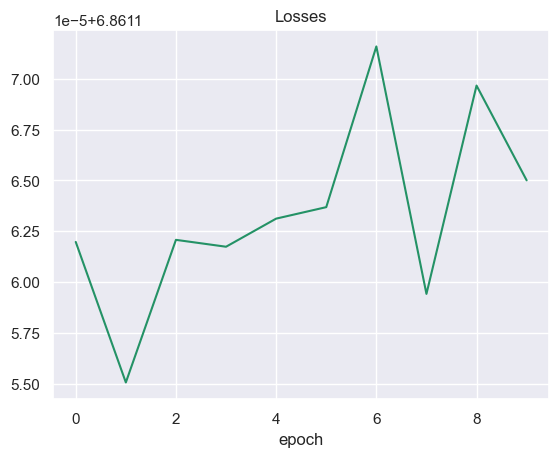

In [114]:
plt.plot(np.arange(len(history2['train_loss'])), history2['train_loss'])
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

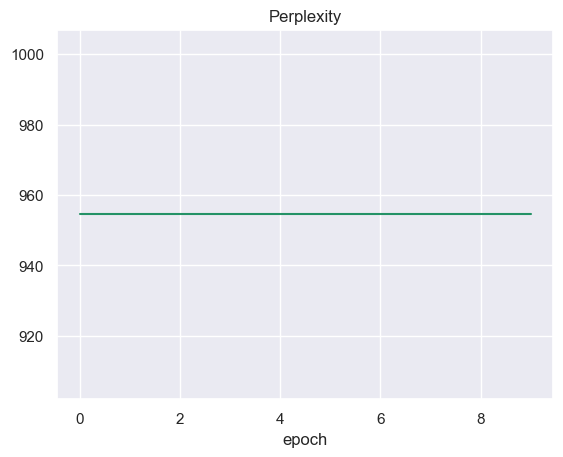

In [115]:
plt.plot(np.arange(len(history2['val_perplexity'])), history2['val_perplexity'])
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.